In [35]:
import jax
import jax.lax as lax
import jax.numpy as jnp
from jax.random import key, split, uniform

import matplotlib.pyplot as plt

jnp.set_printoptions(precision=3)

# Parameter inference for HMMs

In this notebook, we explore the parameter inference of hidden Markov models using the Baum-Welch algorithm.
First we have to define the problem.

In [227]:
seed = 0
n = 5 # Number of states
m = 3 # Number of observations

rng_key = key(seed)
rng_key, O_key, mu_key = split(rng_key, 3)

# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.90 * jnp.eye(n)
T = T + 0.1 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(-jnp.linspace(0, 10, n))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = uniform(O_key, (n, m))
O = O * jnp.linspace(0, 1, n)[:, None]
for s in range(n):
    O = O.at[s, (s * m) // n ].set(.5)
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])

T row sums: [1. 1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1. 1.] 
mu sum: [1.]


The above code defines the true underlying HMM parameters for $T$, $O$ and $\mu$. They look like this: 

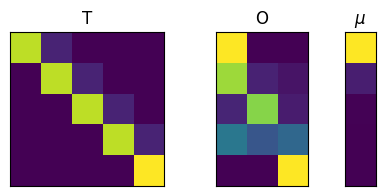

In [229]:
fig, ax = plt.subplots(1, 3, width_ratios=(n, m, 1))
fig.set_size_inches(5,2)
ax[0].imshow(T)
ax[0].set_title("T")
ax[1].imshow(O)
ax[1].set_title("O")
ax[2].imshow(mu[:,None])
ax[2].set_title(r"$\mu$")
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
plt.show()

We are now ready to use our parameters to generate a set of sequences which we will use to train our HMM.

In [230]:
from sequence_sampling import generate_sequence

n_sequences = 10_000
len_sequence = 200
rng_key, *sequence_keys = split(key(seed), 1 + n_sequences)

generate = jax.jit(lambda _key: generate_sequence(_key, T, O, mu, len_sequence))

states, observations = jax.vmap(generate)(jnp.array(sequence_keys))

print("states.shape =", states.shape)

states.shape = (10000, 200)


We can compute some statistics for our sampled sequences:

1. average state at each iteration
2. mean likelihood of the sequences generated
3. distribution of observations at each time step
4. distribution of hidden states at each time steps

Note that the likelihood quickly approaches 0 as the sequence becomes longer. The final plot shows the distributions of different states over time. Towards the end, it is highly likely to be in the final state, from where no other transitions are possible.

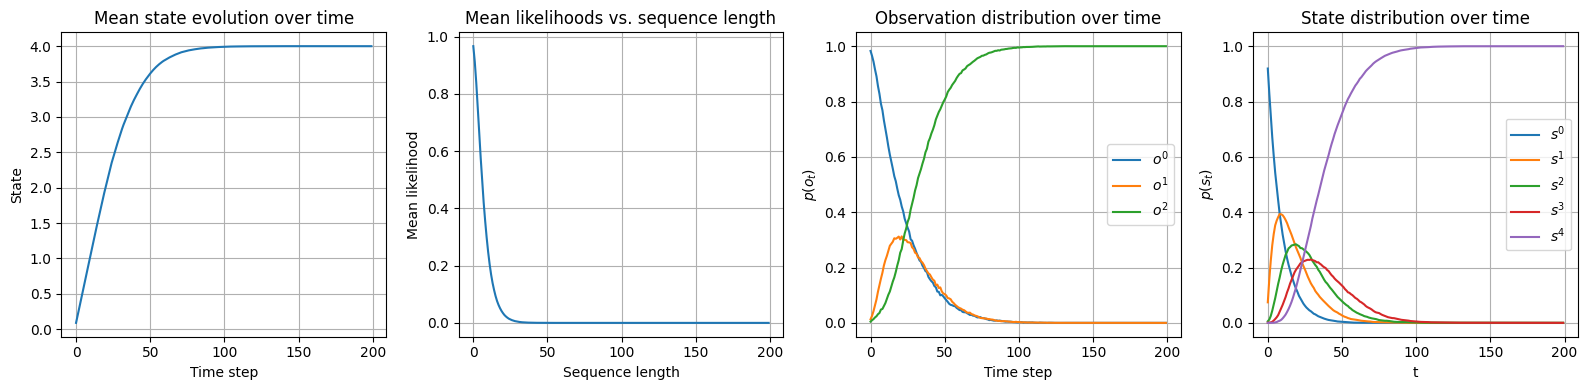

In [231]:
from likelihoods import likelihood

def plot_stats(states, observations):
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(16,4)

    ax[0].set_title("Mean state evolution over time")
    ax[0].plot(jnp.mean(states, axis=0))
    ax[0].grid()
    ax[0].set_xlabel("Time step")
    ax[0].set_ylabel("State")

    _, likelihoods = jax.vmap(lambda obs_seq: likelihood(obs_seq, T, O, mu, return_stats=True))(observations)
    ax[1].set_title("Mean likelihoods vs. sequence length")
    ax[1].plot(jnp.mean(likelihoods, axis=0))
    ax[1].set_xlabel("Sequence length")
    ax[1].set_ylabel("Mean likelihood")
    ax[1].grid()

    obs_distribution = lax.map(lambda o: jnp.count_nonzero(observations == o, axis=0), jnp.arange(m)) / observations.shape[0]
    for k, obs_prob in enumerate(obs_distribution):
        ax[2].plot(obs_prob, label=f"$o^{k}$")
    ax[2].set_title("Observation distribution over time")
    ax[2].grid()
    ax[2].legend()
    ax[2].set_xlabel("Time step")
    ax[2].set_ylabel("$p(o_t)$")

    state_distribution = lax.map(lambda s: jnp.count_nonzero(states == s, axis=0), jnp.arange(n)) / states.shape[0]
    for k, state_prob in enumerate(state_distribution):
        ax[3].plot(state_prob, label=f"$s^{k}$")

    ax[3].set_title("State distribution over time")
    ax[3].set_xlabel("t")
    ax[3].set_ylabel("$p(s_t)$")
    ax[3].grid()
    ax[3].legend()

    plt.tight_layout()
    plt.show()

plot_stats(states, observations)

# The forward backward algorithm

Through the forward backward algorithm, we can compute in an iterative way the conditional probabilities

$$ \mathbb{P}(s_t = s^k | o_{1:t}, T, O, \mu)$$

These probabilities then play a major role in finding a parameter estimate for $O$. We now illustrate the results of forward backward.

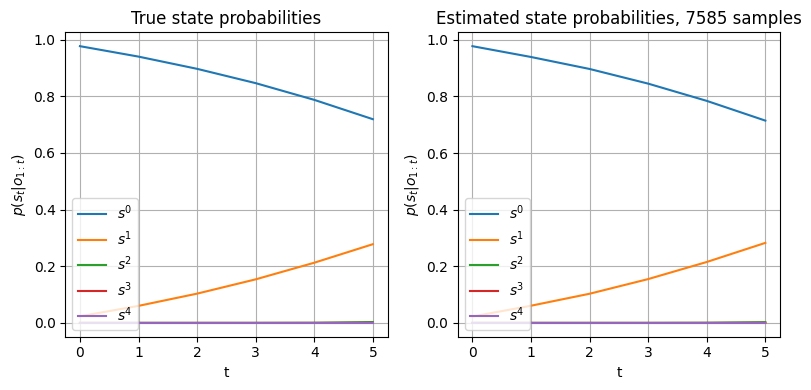

In [232]:
from inference import forward_backward

test_length = 6
test_sequence = observations[0, :test_length]

gamma, xi = forward_backward(test_sequence, T, O , mu)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8,4)

for k, row in enumerate((gamma / jnp.sum(gamma, axis=-1)[:, None]).T):
    ax[0].plot(row, label=f"$s^{k}$")
ax[0].set_title("True state probabilities")

identical_indices = jnp.all(observations[:, :test_length] == test_sequence, axis=-1)
identical_samples = jnp.sum(identical_indices)

filtered_states = states[identical_indices]

state_distr = lax.map(lambda s: jnp.count_nonzero(filtered_states == s, axis=0), jnp.arange(n)) / filtered_states.shape[0]

for k, row in enumerate(state_distr):
    ax[1].plot(row[:test_length], label=f"$s^{k}$")
ax[1].set_title("Estimated state probabilities" + f", {len(filtered_states)} samples")

for k in (0,1):
    ax[k].set_xlabel("t")
    ax[k].set_ylabel("$p(s_t | o_{1:t})$")
    ax[k].grid()
    ax[k].legend(loc="lower left")

plt.tight_layout()
plt.show()

We can now try to estimate the parameters using the vanilla version of the Baum-Welch algorithm.

[[9.911e-01 8.839e-03 3.186e-05 0.000e+00 0.000e+00]
 [0.000e+00 2.042e-27 1.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 9.930e-01 7.007e-03 1.244e-12]
 [0.000e+00 0.000e+00 0.000e+00 5.682e-01 4.318e-01]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00]]


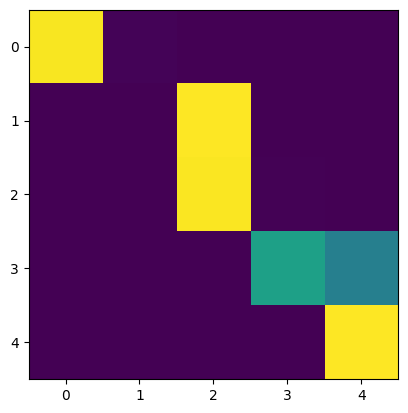

In [234]:
from inference import baum_welch

T_approx, O_approx = baum_welch(observations[0], jnp.triu(uniform(key(0), T.shape)), uniform(key(1), O.shape), mu, epsilon=1e-4)

print(T_approx)
plt.imshow(T_approx)
plt.show()

In [235]:
llhood = likelihood(observations[0], T_approx, O_approx, mu)
llhood

Array(2.925e-21, dtype=float32)

The likelihood estimate is not very good. However, we can improve upon this result by running the algorithm many times using slightly perturbed versions of the previous outcomes as the input.

In [236]:
from likelihoods import log_likelihood

n_steps = 100
n_train = 300

best_llhood = -jnp.inf

T_approx = jnp.zeros_like(T)
O_approx = jnp.zeros_like(O)

T_best = jnp.triu(uniform(key(0), T.shape)) * jnp.tril(jnp.full_like(T, 1.0), 1)
O_best = uniform(key(1), O.shape)

for k in range(n_steps):
    T_init = jnp.triu(uniform(key(k), T.shape)) * jnp.tril(jnp.full_like(T, 1.0), 1)
    O_init = uniform(key(k + n_steps), O.shape)
    T_init = T_init / jnp.sum(T_init, axis=1)[:, None]
    O_init = O_init / jnp.sum(O_init, axis=1)[:, None]
    
    train_indices = jax.random.choice(key(k), jnp.arange(len(observations)), (n_train, ), replace=False)

    T_approx, O_approx = baum_welch(observations[train_indices], T_init, O_init, mu, epsilon=1e-8)

    log_llhood = jax.vmap(lambda _obs: log_likelihood(_obs, T_approx, O_approx, mu))(observations)

    total_loglikelihood = jnp.sum(log_llhood)
    print(k, ":", total_loglikelihood, end="\r")
    if total_loglikelihood >= best_llhood:
        T_best = T_approx.copy()
        O_best = O_approx.copy()
        best_llhood = total_loglikelihood
        print(k, ":", best_llhood)
print(best_llhood)


0 : -1.2255371e+06
6 : -901740.44+066
25 : -896366.56+066
26 : -693845.0
85 : -663887.35e+066
-663887.3755292e+06


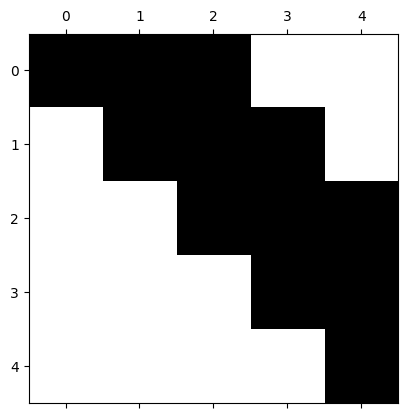

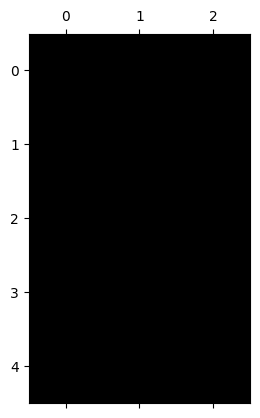

(Array(100, dtype=int32), Array(200, dtype=int32))


In [266]:
from functools import partial

@partial(jax.jit, static_argnames=["batch_size", "parallel_batches"])
def fit_parallel(
    rng_key,
    obs, 
    T_structure, 
    O_structure, 
    mu, 
    batch_size: int = 100, 
    parallel_batches: int = 3_000):

    batch_key, *key_arr = split(rng_key, 1 + parallel_batches)
    train_batches = jax.random.choice(batch_key, len(observations), (parallel_batches, batch_size), replace=True)

    def fit(rng_key, batch):
        key_T, key_O = split(rng_key)

        jax.debug.print("{}", batch.shape)

        _T = uniform(key_T, T_structure.shape) * T_structure
        _O = uniform(key_O, O_structure.shape) * O_structure

        _T = _T / jnp.sum(_T, axis=1)[:, None]
        _O = _O / jnp.sum(_O, axis=1)[:, None]

        return baum_welch(batch, _T, _O, mu)


    _T_arr, _O_arr = jax.vmap(fit, in_axes=(0, 0))(jnp.array(key_arr), obs[train_batches])
    
    return _T_arr, _O_arr

T_structure = jnp.tril(jnp.triu(jnp.ones_like(T)), 2)
O_structure = jnp.ones_like(O)

plt.spy(T_structure)
plt.show()

plt.spy(O_structure)
plt.show()

T_arr, O_arr = fit_parallel(key(0), observations, T_structure, O_structure,  mu)


In [267]:
T_estimate = jnp.nanmean(T_arr, axis=0)
O_estimate = jnp.nanmean(O_arr, axis=0)

T_estimate = T_estimate / jnp.sum(T_estimate, axis=-1)[:,None]
O_estimate = O_estimate / jnp.sum(O_estimate, axis=-1)[:,None]

true_llhood = jax.vmap(lambda _obs: log_likelihood(_obs, T, O, mu))(observations)
print("Log likelihood of training sequences for true params:", jnp.sum(true_llhood))

estimated_llhood = jax.vmap(lambda _obs: log_likelihood(_obs, T_estimate, O_estimate, mu))(observations)
print("Log likelihood of training sequences for estimted params:", jnp.sum(estimated_llhood))

Log likelihood of training sequences for true params: -2.4590622e+06
Log likelihood of training sequences for estimted params: -3.1759518e+06


[1. 1. 1. 1. 1.]
[[0.726 0.157 0.118 0.    0.   ]
 [0.    0.742 0.142 0.117 0.   ]
 [0.    0.    0.709 0.174 0.118]
 [0.    0.    0.    0.646 0.354]
 [0.    0.    0.    0.    1.   ]]


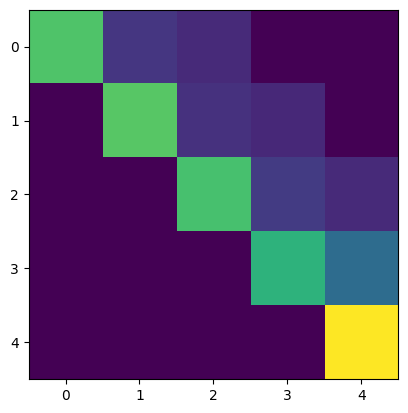

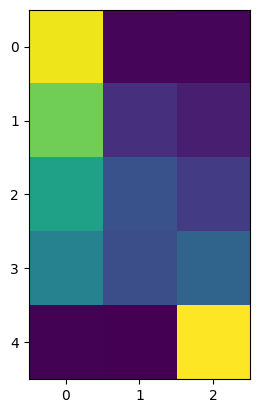

In [268]:
print(jnp.sum(T_estimate, axis=1))
print(T_estimate)

plt.imshow(T_estimate)
plt.show()
plt.imshow(O_estimate)
plt.show()

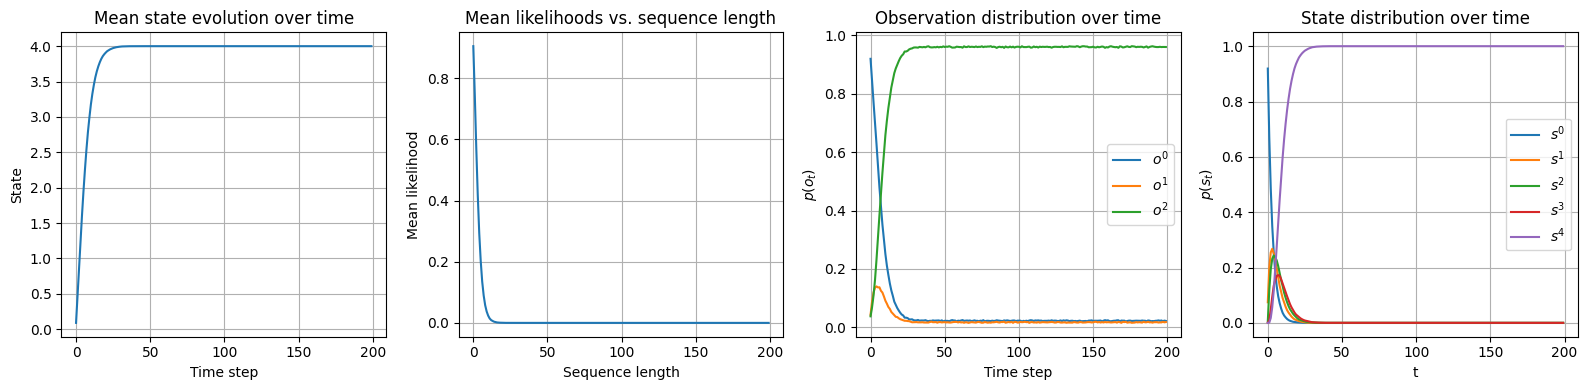

In [269]:
states_approx, obs_approx = jax.vmap(lambda _key: generate_sequence(_key, T_estimate, O_estimate, mu, len_sequence))(jnp.array(split(key(0), 20_000)))
plot_stats(states_approx, obs_approx)

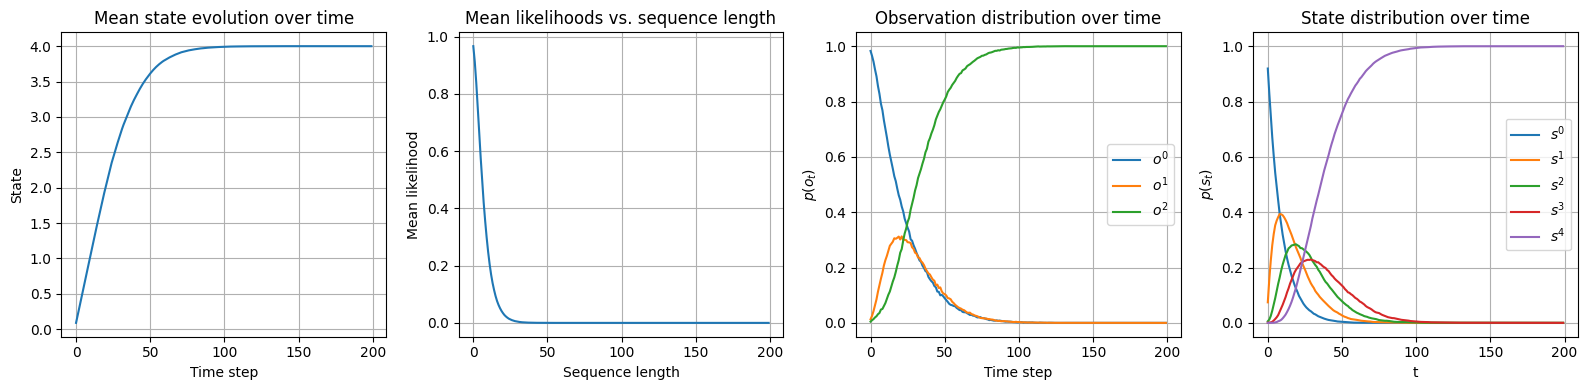

In [253]:
plot_stats(states, observations)